In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj


In [2]:
ccf_files_path = "/home/benjami/mnt/zador_data_norepl/Ari/transcriptomics/CCF_files"

bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name




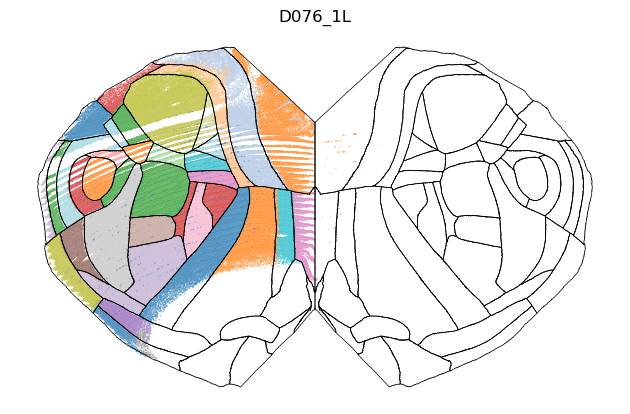

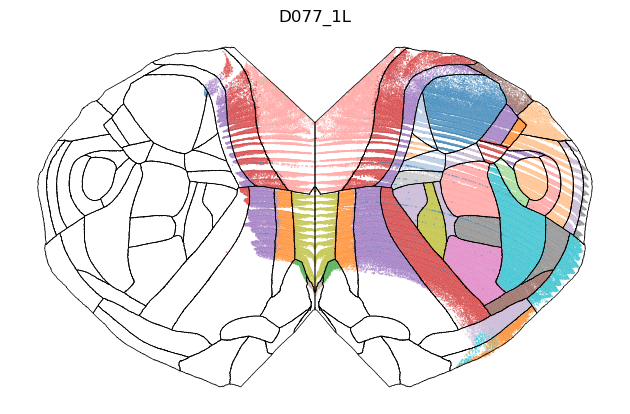

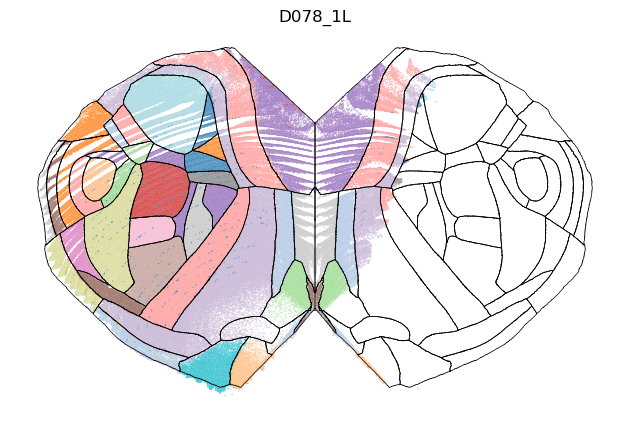

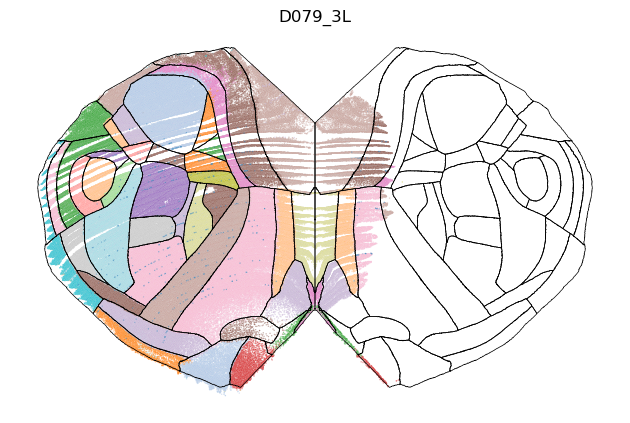

In [3]:
#get system variable
data_dir = os.environ.get('ROOT_DATA_PATH')

animals = ["filt_neurons_D076_1L_CCFv2_newtypes.h5ad",
    "filt_neurons_D077_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D077_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D078_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D078_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D079_3L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D079_4L_CCFv2_newtypes.h5ad"
    ]

#load data
for animal in animals:
    adata = ad.read_h5ad(os.path.join(data_dir, 'barseq/Chen2023', animal), backed='r')
    animal_name = '_'.join(animal.split('_')[2:4])
    adata.obs['CCFano'] = adata.obs['CCFano'].astype('category')
    adata.obs['CFFname'] = adata.obs['CCFname'].astype('category')
    adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
    adata.obs['area_name'] = adata.obs['area_label'].map(area_class2area_name).astype('category')


    df = pd.DataFrame(adata.obsm['CCF_streamlines'], columns=['x', 'y','z'])
    df['CCFano'] = adata.obs['CCFano'].values
    df['area_name'] = adata.obs['area_name'].values

    sns.scatterplot(df, x='x', y='y', hue='area_name', palette='tab20', alpha=0.5, s=1, legend='brief')
    plt.legend('', frameon=False)
    plt.title(animal_name)

    for k, boundary_coords in bf_left_boundaries_flat.items():
        plt.plot(*boundary_coords.T, c="k", lw=0.5)
    for k, boundary_coords in bf_right_boundaries_flat.items():
        plt.plot(*boundary_coords.T, c="k", lw=0.5)

    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    # plt.savefig(f'../figures/CCF_areas_{animal_name}.png', dpi=300)
    plt.show()


In [2]:
from datasets import load_from_disk
from transformers import TrainingArguments, PreTrainedModel, AutoConfig
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict

import sys 
sys.path.append('..')
from samplers import SpatialGroupCollator, SpatialGroupSampler, DistributedSpatialGroupSampler

import torch
import torch.distributed as dist
from torch.utils.data import Sampler, Dataset
import numpy as np
import math

from typing import Iterator, List, Optional, Tuple
from dataclasses import dataclass
from transformers import Trainer

from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from collections import Counter
import collections

# Dummy model for testing
class NullModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.dummy_param = torch.nn.Parameter(torch.zeros(1))
    
    def forward(self, **kwargs):
        return None

# Load dataset and create trainer
def create_test_trainer(dataset_path: str, group_size: int = 32, window_size: float = 0.1):
    # Load dataset
    dataset = load_from_disk(dataset_path)
    
    # Create minimal training arguments
    training_args = TrainingArguments(
        output_dir="./test_trainer",
        per_device_train_batch_size=1,  # Since each "example" is a group
        num_train_epochs=1,
        remove_unused_columns=False,
    )
    
    # Create dummy model
    config = AutoConfig.from_pretrained("bert-base-uncased")
    model = NullModel(config)
    
    # Create trainer
    trainer = MultiformerTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        spatial_group_size=group_size,
        spatial_window_size=window_size,
        spatial_label_key="CCFano"  # Adjust if your label key is different
    )
    
    return trainer, dataset

# Function to examine a batch
def print_batch_info(batch: Dict[str, torch.Tensor]):
    print("\nBatch Structure:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: shape {value.shape}, dtype {value.dtype}")
    
    num_groups = batch["input_ids"].shape[0]
    print(f"\nNumber of groups in batch: {num_groups}")
    print(f"Number of sentences per group: {batch['input_ids'].shape[1]}")

# Function to visualize spatial groups
def plot_spatial_groups(dataset, batch_indices, group_size: int, num_examples: int = 4):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()
    
    # Create colormap for labels
    unique_labels = np.unique([dataset[idx]["labels"] for idx in batch_indices[:group_size*num_examples]])
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    
    for i in range(num_examples):
        ax = axes[i]
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group_indices = batch_indices[start_idx:end_idx]
        
        # Get coordinates and labels
        coordinates = np.array([dataset[idx]["CCF_streamlines"] for idx in group_indices])
        labels = np.array([dataset[idx]["labels"] for idx in group_indices])
        
        # Get majority label for color
        unique, counts = np.unique(labels, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        
        # Plot points
        ax.scatter(coordinates[:, 0], coordinates[:, 1], 
                  color=label_to_color[majority_label],
                  alpha=0.6, s=100)
        
        # Plot centroid
        centroid = coordinates.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], color='black', marker='*', s=200,
                  label=f'Centroid (Label: {majority_label})')
        
        ax.set_title(f'Group {i+1}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    return fig

# Test the setup
def test_spatial_sampling(dataset_path: str):
    # Create trainer
    trainer, dataset = create_test_trainer(dataset_path)
    
    # Get dataloader
    train_dataloader = trainer.get_train_dataloader()
    
    # Get one batch and print info
    batch = next(iter(train_dataloader))
    print_batch_info(batch)
    
    # Get indices from sampler for visualization
    sampler_indices = list(trainer.train_dataset.sampler)
    
    # Plot some examples
    fig = plot_spatial_groups(dataset["train"], sampler_indices, 
                            group_size=trainer.spatial_group_size)
    
    return fig

class MultiformerTrainer(Trainer):
    def __init__(self, *args, additional_attributes=None, 
                 spatial_group_size=32, 
                 spatial_label_key='area_labels', **kwargs):
        kwargs["data_collator"] = SpatialGroupCollator(
            group_size=spatial_group_size,
            label_key=spatial_label_key,
            feature_keys=["input_ids", 'CCF_streamlines'],  # Add other feature keys as needed
            pad_token_id=0 # Adjust as needed
        )
        # Store spatial sampling parameters
        self.spatial_group_size = spatial_group_size
        
        super().__init__(*args, **kwargs)

        assert self.args.train_batch_size % spatial_group_size == 0, \
            "train_batch_size must be divisible by spatial_group_size"

    def _get_train_sampler(self) -> Optional[torch.utils.data.sampler.Sampler]:
        if not isinstance(self.train_dataset, collections.abc.Sized):
            return None

        generator = None
        if self.args.world_size <= 1:
            generator = torch.Generator()
            generator.manual_seed(
                int(torch.empty((), dtype=torch.int64).random_().item())
            )

        # Build the sampler.
        # Use spatial sampling
        if self.args.world_size <= 1:
            return SpatialGroupSampler(
                dataset=self.train_dataset,
                batch_size=self.args.train_batch_size,
                group_size=self.spatial_group_size,
                seed=self.args.seed
            )
        else:
            return DistributedSpatialGroupSampler(
                dataset=self.train_dataset,
                batch_size=self.args.train_batch_size,
                num_replicas=self.args.world_size,
                rank=self.args.process_index,
                seed=self.args.seed,
                group_size=self.spatial_group_size,
            )

    def _get_eval_sampler(self, eval_dataset) -> Optional[torch.utils.data.sampler.Sampler]:
        if not isinstance(eval_dataset, collections.abc.Sized):
            return None

        generator = None
        if self.args.world_size <= 1:
            generator = torch.Generator()
            generator.manual_seed(
                int(torch.empty((), dtype=torch.int64).random_().item())
            )

        # Build the sampler.
        # Use spatial sampling for evaluation
        if self.args.world_size <= 1:
            return SpatialGroupSampler(
                dataset=eval_dataset,
                batch_size=self.args.eval_batch_size,
                group_size=self.spatial_group_size,
                seed=self.args.seed
            )
        else:
            return DistributedSpatialGroupSampler(
                dataset=eval_dataset,
                batch_size=self.args.eval_batch_size,
                num_replicas=self.args.world_size,
                rank=self.args.process_index,
                seed=self.args.seed,
                group_size=self.spatial_group_size,
            )
        

In [3]:
dataset_path = "/home/benjami/brain-annotation/data/train_test_barseq.dataset"  # Replace with your dataset path

dataset = load_from_disk(dataset_path)

# Create minimal training arguments
training_args = TrainingArguments(
output_dir="./test_trainer",
num_train_epochs=1,
remove_unused_columns=False,
per_device_train_batch_size=32
)

# Create dummy model
config = AutoConfig.from_pretrained("bert-base-uncased")
model = NullModel(config)


group_size = 32
window_size = 0.01


Text(0.5, 1.0, 'Areas of the CCF')

/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


Error in callback <function _draw_all_if_interactive at 0x78859db50680> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


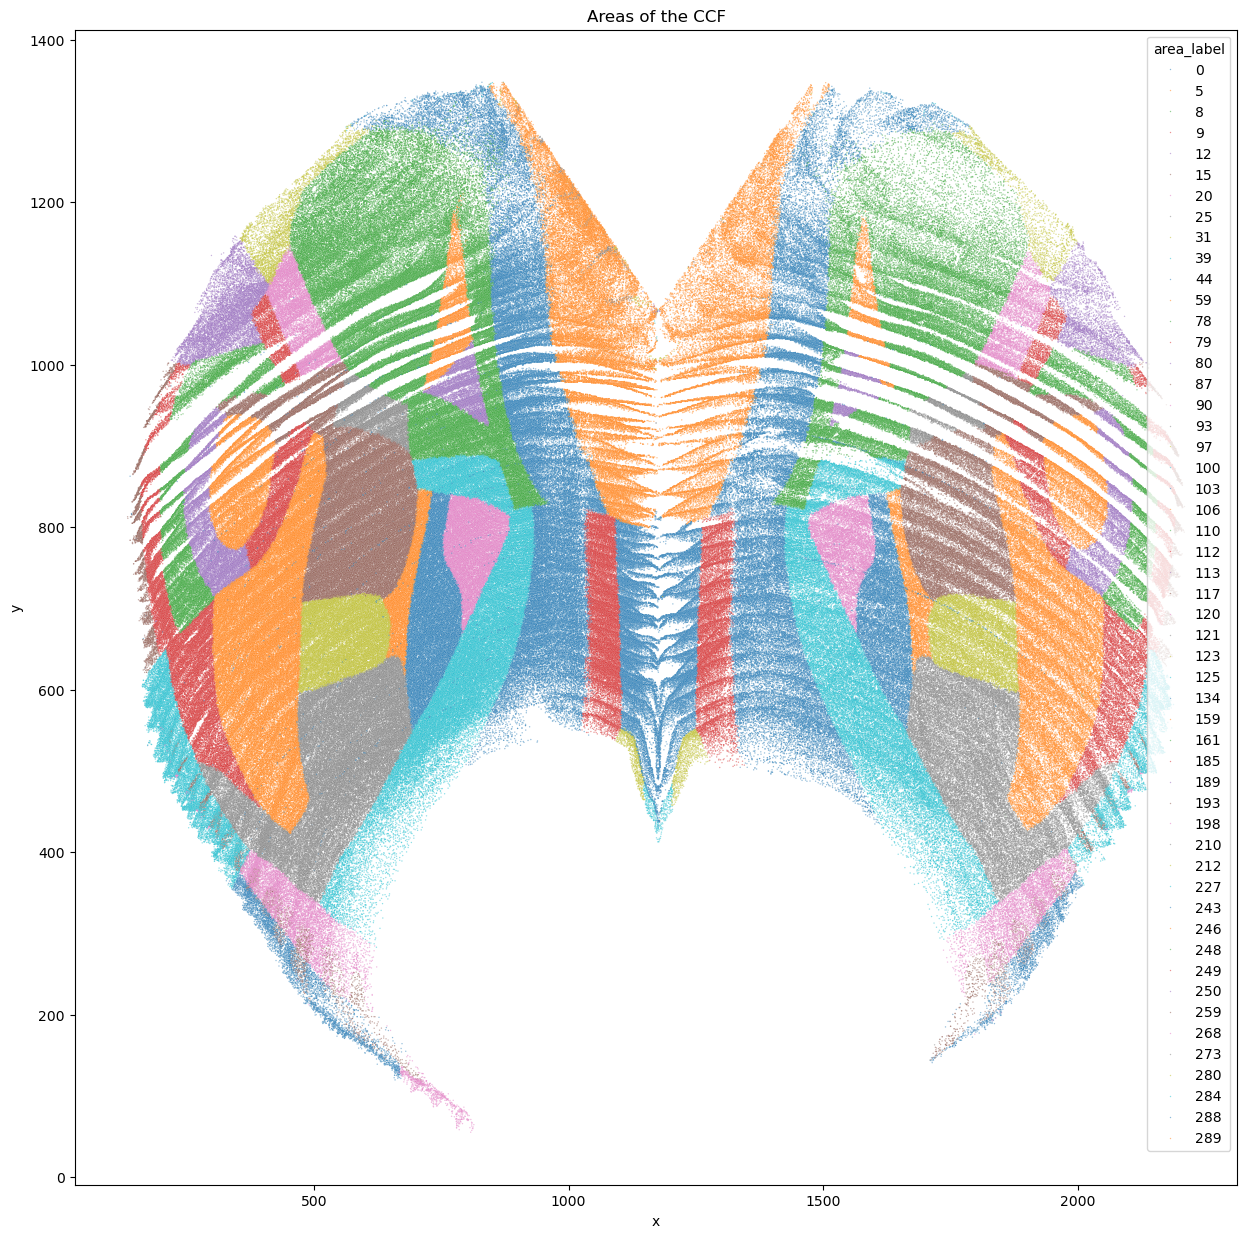

In [12]:
plt.figure(figsize=(15, 15))
df = pd.DataFrame(dataset['train']['area_label'], columns=['area_label'])
xyz = np.array(dataset['train']['CCF_streamlines'])
df['x'] = xyz[:,0]
df['y'] = xyz[:,1]
df['z'] = xyz[:,2]
sns.scatterplot(df, x='x', y='y', hue='area_label', palette='tab10', alpha=0.5, s=1)
plt.title("Areas of the CCF")


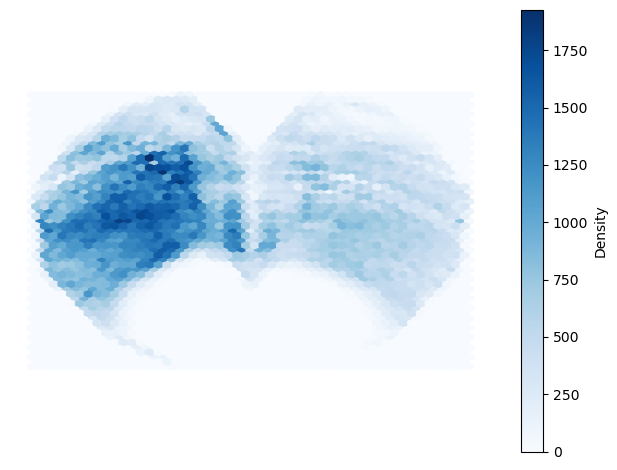

In [36]:
plt.hexbin(df['x'],df['y'], gridsize=50,cmap='Blues', ) 
# (x=df['x'], y=df['y'], gridsize=50, cmap='Blues', kind='hex')
# plt.title("Jointplot of CCF Streamlines")
# plot the density cmap legend
plt.colorbar(label='Density')

plt.gca().set_aspect('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig('butterfly_density.png', dpi=300)
plt.show()

/tmp/ipykernel_2754718/678946659.py:95: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


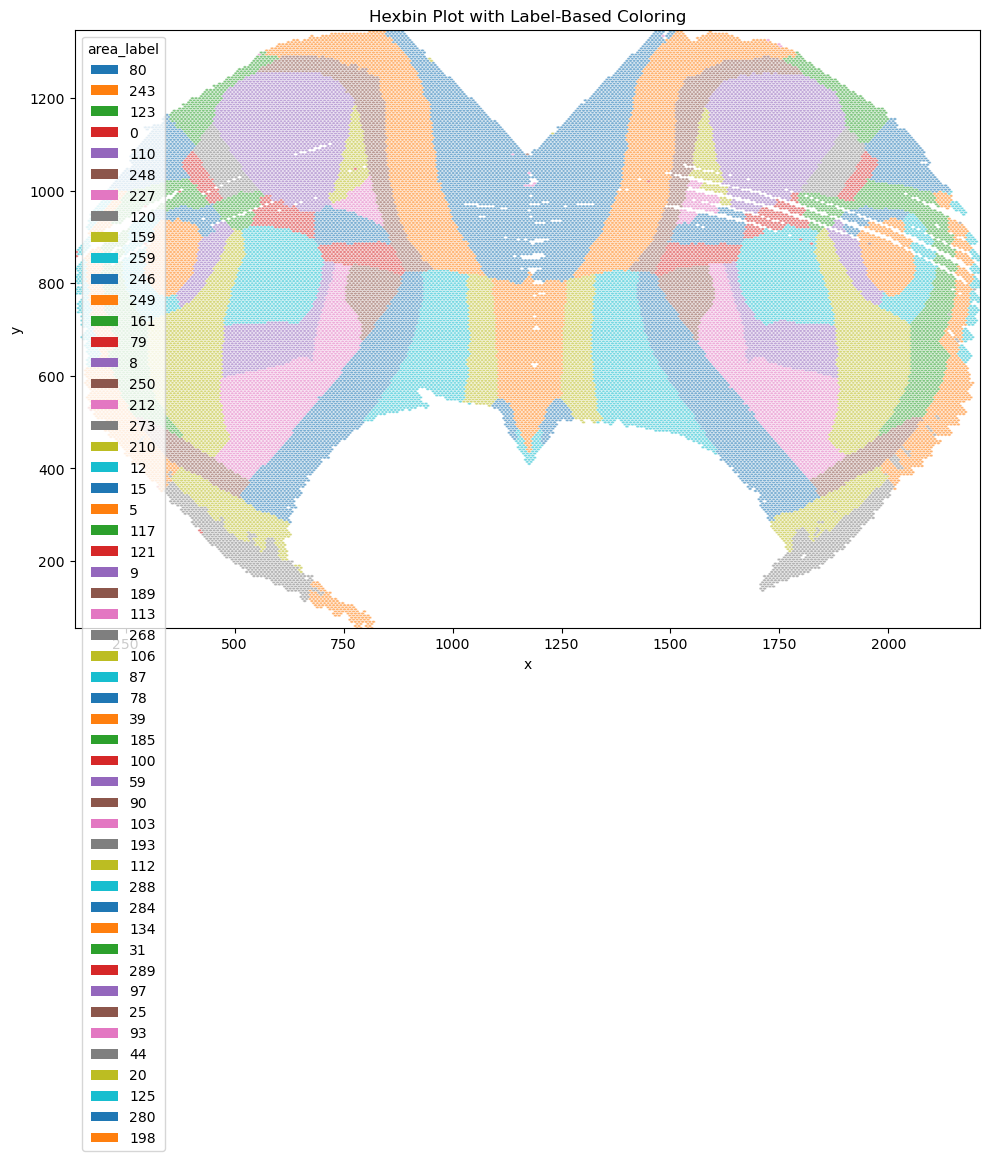

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

def plot_labeled_hexbin(df, x_col, y_col, label_col, gridsize=30, figsize=(10, 8), 
                       cmap='viridis', title=None):
    """
    Create a hexbin plot where each hexagon is colored by the most common label in that region.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    x_col : str
        Column name for x-axis values
    y_col : str
        Column name for y-axis values
    label_col : str
        Column name for labels
    gridsize : int, optional
        Number of hexagons in the plot (default: 30)
    figsize : tuple, optional
        Figure size (width, height) in inches
    cmap : str, optional
        Colormap to use for different labels
    title : str, optional
        Plot title
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate the hex size based on data range
    x_range = df[x_col].max() - df[x_col].min()
    y_range = df[y_col].max() - df[y_col].min()
    hex_size = np.sqrt(x_range * y_range / (gridsize ** 2))
    
    # Get hexbin coordinates
    hb = ax.hexbin(df[x_col], df[y_col], gridsize=gridsize, visible=False)
    
    # Get hexagon locations and paths
    offsets = hb.get_offsets()
    paths = hb.get_paths()
    
    # Clear the invisible hexbin
    ax.cla()
    
    # Get unique labels and assign colors
    unique_labels = df[label_col].unique()
    color_dict = dict(zip(unique_labels, 
                         sns.color_palette(cmap, n_colors=len(unique_labels))))
    
    # For each hexagon
    for offset in offsets:
        # Find points within this hexagon using hex_size
        mask = ((df[x_col] - offset[0])**2 + (df[y_col] - offset[1])**2 <= hex_size**2)
        
        if mask.any():
            # Get most common label in this hexagon
            labels_in_hex = df[label_col][mask]
            if len(labels_in_hex) > 0:
                most_common_label = mode(labels_in_hex, keepdims=True)[0][0]
                
                # Draw the hexagon with the appropriate color
                hex_path = paths[0].transformed(plt.matplotlib.transforms.Affine2D().translate(*offset))
                patch = plt.matplotlib.patches.PathPatch(hex_path, 
                                                       facecolor=color_dict[most_common_label],
                                                       alpha=0.6,
                                                       edgecolor='white',
                                                       linewidth=0.5)
                ax.add_patch(patch)
    
    # Add legend
    legend_elements = [plt.matplotlib.patches.Patch(facecolor=color_dict[label],
                                                  label=str(label))
                      for label in unique_labels]
    ax.legend(handles=legend_elements, title=label_col)
    
    # Set labels and title
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if title:
        ax.set_title(title)
    
    # Set reasonable axis limits
    ax.set_xlim(df[x_col].min(), df[x_col].max())
    ax.set_ylim(df[y_col].min(), df[y_col].max())
    
    plt.tight_layout()
    return fig

fig = plot_labeled_hexbin(df, 'x', 'y', 'area_label', cmap="tab10", figsize=(10, 10),
                         gridsize=250, 
                         title='Hexbin Plot with Label-Based Coloring')


In [ ]:
# subselect data for testing
train_dataset_subset = dataset["train"].select(range(20000))
train_dataset_subset = train_dataset_subset.filter(lambda x: not np.isnan(np.sum(x['CCF_streamlines'])))
train_dataset_subset

Dataset({
    features: ['input_ids', 'id', 'H2_type', 'CCF_streamlines', 'CCFparentname', 'CCF', 'CCFname', 'H1_type', 'CCFano', 'H3_type', 'length', 'area_label'],
    num_rows: 20000
})

In [5]:

trainer = MultiformerTrainer(
model=model,
args=training_args,
train_dataset=dataset["train"],
spatial_group_size=32,
spatial_label_key="area_label",)  # Adjust if your label key is different  )

[2024-11-06 10:41:34,360] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/benjami/micromamba/envs/geneformer2/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/benjami/micromamba/envs/geneformer2/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [6]:
train_dataloader = trainer.get_train_dataloader()

batch = next(iter(train_dataloader))
print_batch_info(batch)

Precomputing spatial data...
KD-tree construction complete. Initial radius: 7.4000

Batch Structure:
input_ids: shape torch.Size([2, 32, 106]), dtype torch.int64
CCF_streamlines: shape torch.Size([2, 32, 106]), dtype torch.float32
single_cell_labels: shape torch.Size([2, 32]), dtype torch.int64
area_label: shape torch.Size([2]), dtype torch.int64

Number of groups in batch: 2
Number of sentences per group: 32


In [7]:
import ccf_streamlines.projection as ccfproj

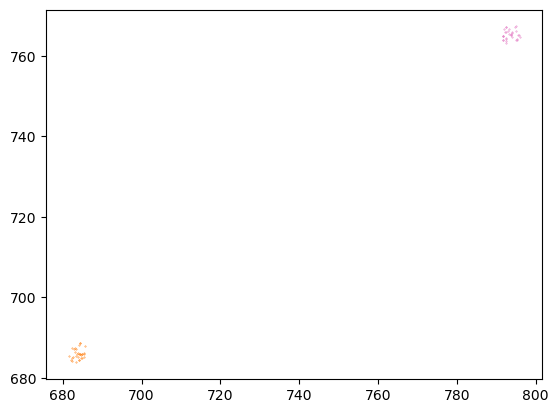

In [12]:
# plt.scatter(adata.obsm['CCF_streamlines'][:, 0], adata.obsm['CCF_streamlines'][:, 1], s=0.1, alpha=0.01)
# Get dataloader
i=0
categories = np.unique(dataset['train']['area_label'])
cs = sns.color_palette("tab10", len(categories))
ccf_files_path = "/home/benjami/mnt/zador_data_norepl/Ari/transcriptomics/CCF_files"
for batch in train_dataloader:
    for j in range(len(batch['CCF_streamlines'])):
        color_idx = categories.tolist().index(batch['area_label'].cpu().numpy()[j])
        color = cs[color_idx]

        single_cell_color_idx = [categories.tolist().index(z) for z in batch['single_cell_labels'][j].cpu().numpy()]
        single_cell_color = [cs[k] for k in single_cell_color_idx]

        plt.scatter(batch['CCF_streamlines'][j, :, 0].cpu(), 
                    batch['CCF_streamlines'][j, :, 1].cpu(), s=0.1, color=color)
        i+=1
        break

    if i>1:
        break


# bf_boundary_finder = ccfproj.BoundaryFinder(
#     projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
#     labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
# )

# bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
# bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
#     hemisphere='right_for_both',
#     view_space_for_other_hemisphere='flatmap_butterfly',
# )

# plt.grid(False)
# for k, boundary_coords in bf_left_boundaries_flat.items():
#     plt.plot(*boundary_coords.T, c="k", lw=0.5)
# for k, boundary_coords in bf_right_boundaries_flat.items():
#     plt.plot(*boundary_coords.T, c="k", lw=0.5)

# plt.axis('off')
# plt.gca().set_aspect('equal')
# plt.tight_layout()
# plt.savefig('butterfly_boundaries.png', dpi=300)
plt.show()
